# Problema de Classificação: Churn da empresa Olist

O objetivo é fornecer uma solução para um problema da empresa Olist, baseado na detecção dos clientes mais propensos a não venderem nenhum produto futuramente.  
Em termos técnicos, a empresa precisa de um **modelo preditivo de churn.**

O atual projeto foi dividido em 9 etapas, que são:

**1. Entendimento do Negócio**  
**2. Entendimento do problema**  
**3. Obtenção dos dados**  
**4. Exploração dos dados**  
**5. Preparação dos dados**  
**6. Modelagem e seleção de algoritmos**  
**7. Aperfeiçoamento do modelo**  
**8. Apresentação da solução**  
**9. Implementação e monitoramento**




## 1. Entendimento do Negócio

<img src = 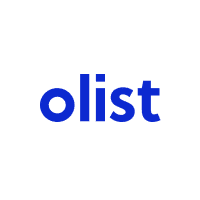>

A Olist é uma plataforma para vendas e-commerce. Ela permite que o vendedor tenha acesso a uma gama de marketplaces muito maior do que teria por conta própria, alavancando suas vendas online.

É interessante para a Olist que os vendedores que usam a plataforma realizem vendas e prosperem, visto que os vendedores que não realizam vendas podem perder o interesse em usar a plataforma.

## 2. Entendimento do Problema

A Olist precisa detectar os clientes mais propensos a não realizar vendas no futuro (próximos 6 meses). 

A ideia da empresa é oferecer cupons para os vendedores, para que eles possam realizar vendas e evitar eventuais quedas no faturamento da Olist.

**Resumo do problema**
1. Detectar vendedores que não venderão nos próximos 6 meses;
2. Problema de classificação - aprendizado supervisionado;
3. Os clientes detectados pelo modelo receberão o cupom;
4. Os dados históricos para construção do modelo são fornecidos pela empresa;
5. Conseguimos avaliar o impacto financeiro de acordo com a quantidade de cupons fornecidos.

## 3. Obtenção dos Dados

Os dados fornecidos pela Olist estão no diretório Kaggle: 
https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce

Como precisamos detectar os **vendedores** que não vão realizar vendas **(transações/pedidos)**, usaremos as informações de pedidos, de transações e de vendedores.

### 3.1 Preparação do ambiente

In [1]:
pip install xgboost lightgbm catboost feature_engine

Note: you may need to restart the kernel to use updated packages.


_(Antes de prosseguir, é necessário reiniciar o Kernel)_

In [1]:
# Carregando as bibliotecas que são necessárias para o projeto:

# !pip install os pandas numpy matplotlib
# !pip install feature_engine
# !pip install lightgbm xgboost catboost


import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import dateutil

from sklearn.pipeline import Pipeline
from feature_engine.imputation import ArbitraryNumberImputer, MeanMedianImputer
from feature_engine.imputation import CategoricalImputer
from feature_engine.encoding import OneHotEncoder
from feature_engine.wrappers import SklearnTransformerWrapper
from sklearn.preprocessing import StandardScaler

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from sklearn.model_selection import GridSearchCV

import pickle


### 3.2 Carregando os dados de pedidos

In [2]:
datasets_input = r'D:\diego\OneDrive\Documentos\Data Science\01_Projetos\Olist\input'

In [3]:
datasets_output = r'D:\diego\OneDrive\Documentos\Data Science\01_Projetos\Olist\output'

In [4]:
df_orders = pd.read_csv(os.path.join(datasets_input, 'olist_orders_dataset.csv'), parse_dates=['order_approved_at'])
df_orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


### 3.3 Carregando os dados de transações (items/pedido)

In [5]:
df_order_items = pd.read_csv(os.path.join(datasets_input, 'olist_order_items_dataset.csv'))
df_order_items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


### 3.4 Carregando os dados de vendedores

In [6]:
df_sellers = pd.read_csv(os.path.join(datasets_input, 'olist_sellers_dataset.csv'))
df_sellers.head()

,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP
2,ce3ad9de960102d0677a81f5d0bb7b2d,20031,rio de janeiro,RJ
3,c0f3eea2e14555b6faeea3dd58c1b1c3,4195,sao paulo,SP
4,51a04a8a6bdcb23deccc82b0b80742cf,12914,braganca paulista,SP


## 4. Exploração dos Dados

Podemos explorar um pouco os dados, para conhecer as informações que temos disponíveis.
Algumas perguntas que podem ajudar na resolução do problema:

1. Quantos pedidos temos?
2. Qual o tamanho do histórico disponível?
3. Qual o percentual de pedidos concluídos (entregues ao cliente)?
4. Temos dados faltantes em alguma das tabelas?

In [7]:
# 1. Quantos pedidos temos?
print(f"Total de Pedidos: {df_orders['order_id'].nunique()}")

Total de Pedidos: 99441


In [8]:
# 2. Qual o tamanho do histórico disponível?

df_orders.agg({'order_approved_at': ['max', 'min']})

,order_approved_at
max,2018-09-03 17:40:06
min,2016-09-15 12:16:38


Temos um histórico de 2 anos disponível.

In [9]:
# 3. Qual o percentual de pedidos concluídos (entregues ao cliente)?

df_orders['order_status'].value_counts(1)

delivered      0.970203
shipped        0.011132
canceled       0.006285
unavailable    0.006124
invoiced       0.003158
processing     0.003027
created        0.000050
approved       0.000020
Name: order_status, dtype: float64

97% dos pedidos foram concluídos.

In [10]:
# 4. Temos dados faltantes em alguma das tabelas?

df_orders.isnull().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

In [11]:
df_order_items.isnull().sum()

order_id               0
order_item_id          0
product_id             0
seller_id              0
shipping_limit_date    0
price                  0
freight_value          0
dtype: int64

In [12]:
df_sellers.isnull().sum()

seller_id                 0
seller_zip_code_prefix    0
seller_city               0
seller_state              0
dtype: int64

Temos dados faltantes na tabela de pedidos.

## 5. Preparação dos Dados

O primeiro passo de preparação será juntar as informações em uma única tabela. O objetivo é montar uma ABT (Analytical Base Table), que será o nosso dataset de treinamento.

Como o objetivo do modelo é prever o vendedor que não realizará uma venda, cada instância da tabela precisará ser um vendedor (seller_id).

Será necessário cruzar as informações pela mais baixa granularidade possível e depois agrupar por vendedor.

Vamos utilizar um histórico de **18 meses**, sendo 12 meses de atributos (features) e 6 meses para a variável resposta se o vendedor vendeu ou não (target).

O modelo precisará trabalhar no conceito de "safra", cada uma delas contendo os 18 meses citados acima. Isso é importante para detectar o comportamento de cada vendedor, que pode se alterar ao longo do tempo.

**Construção de features:** Algumas informações interessantes não estão necessariamente prontas nas bases de dados. Por exemplo: _Qual a localização do vendedor? Quantas vendas o vendedor realizou no período? Qual foi a receita obtida? Quando ele vendeu pela última vez? Quanto tempo faz que ele não realiza uma venda?_ Essas questões podem ajudar a responder o problema de Negócio, sendo interessante manipular os dados e criar essas variáveis (features) para que o algoritmo possa utilizar na modelagem. Para isso, usaremos os 12 meses anteriores ao mês de referência da safra.

**Construção da variável target:** Ainda não temos nenhum rótulo pronto que indique se o vendedor realizou ou não uma venda nos 6 meses seguintes. Para o nosso problema de aprendizado supervisionado, precisamos construir essa variável-alvo que corresponde ao "churn". Ela será feita utilizando os 6 meses seguintes ao mês de referência da safra.

### 5.1 Criação da base de modelagem

In [13]:
df_abt_safras = pd.DataFrame()

safras = [
    '2017-10-01', '2017-11-01', '2017-12-01',
    '2018-01-01', '2018-02-01', '2018-03-01'
]  # Determina as safras de treinamento
 
for safra in safras:
    data_ref_safra = pd.to_datetime(safra).date()
    data_ini_inclusiva = data_ref_safra - dateutil.relativedelta.relativedelta(months=12)      # 12 meses de histórico
    data_fim_exclusiva = data_ref_safra + dateutil.relativedelta.relativedelta(months=6)       # 6 meses de previsão
    print(f"Safra: {data_ref_safra}; Data inicial: {data_ini_inclusiva}; Data final: {data_fim_exclusiva}")

    # Selecionando o período histórico de cada safra
    df_historico_abt_train = (
        df_order_items
        .merge(df_orders, on='order_id', how='inner')
        .query("order_status == 'delivered'")
        .query(f"order_approved_at >= '{data_ini_inclusiva}' & order_approved_at < '{data_fim_exclusiva}' ")
        .merge(df_sellers, on='seller_id', how='left')
    )
    
    # Construção das features
    df_features_train = (
        df_historico_abt_train
        .query(f"order_approved_at < '{data_ref_safra}'")       # pega o "passado" da safra
        .groupby('seller_id')                                   # cada instância da base de modelagem é um vendedor
        .agg(
            uf = ('seller_state', 'first'),                     # UF do vendedor
            tot_orders_12m = ('order_id', 'nunique'),           # total de pedidos
            tot_items_12m = ('product_id', 'count'),            # quantidade total de itens vendidos
            tot_items_dist_12m = ('product_id', 'nunique'),     # quantidade de itens distintos vendidos
            receita_12m = ('price', 'sum'),                     # receita obtida nos 12m 
            data_ult_vnd = ('order_approved_at', 'max')         # data da última venda
        )
        .reset_index()
        .assign(data_ref = pd.to_datetime(f'{data_ref_safra}'))
        .assign(recencia = lambda df: (df['data_ref'] - df['data_ult_vnd']).dt.days)  # Há quantos dias ele não realiza uma venda
    )

    # Construção do target
    df_target = (
        df_historico_abt_train
        .query(f"order_approved_at >= '{data_ref_safra}' & order_approved_at < '{data_fim_exclusiva}' ")  # 6 meses do "futuro"
        .filter(['seller_id'])                                                                            # basta saber se o vendedor realizou alguma venda
        .drop_duplicates()
    )

    # Juntando features e target
    df_abt_train =(
        df_features_train                                                                       # partindo da tabela de features
        .merge(df_target, how='left', on='seller_id', indicator=True)                           # cruza com a tabela do target ("ensino a resposta")
        .assign(churn = lambda df: np.where(df['_merge'] == 'left_only', 1, 0))                 # cria o target binário, sendo 1 para quem não realizou uma venda e 0 para quem realizou 
        .filter([                                                                               # filtra as variáveis de interesse
            'data_ref',
            'seller_id',
            'uf',
            'tot_orders_12m',
            'tot_items_12m',
            'tot_items_dist_12m',
            'receita_12m',
            'recencia',
            'churn'
        ])
    )
    
    # Empilha a safra no Dataframe chamado df_abt_safras
    df_abt_safras = pd.concat([df_abt_safras, df_abt_train])


Safra: 2017-10-01; Data inicial: 2016-10-01; Data final: 2018-04-01
Safra: 2017-11-01; Data inicial: 2016-11-01; Data final: 2018-05-01
Safra: 2017-12-01; Data inicial: 2016-12-01; Data final: 2018-06-01
Safra: 2018-01-01; Data inicial: 2017-01-01; Data final: 2018-07-01
Safra: 2018-02-01; Data inicial: 2017-02-01; Data final: 2018-08-01
Safra: 2018-03-01; Data inicial: 2017-03-01; Data final: 2018-09-01


### 5.2 Exploração da base de modelagem

Primeiramente, vamos checar quantas instâncias (observações) temos em cada uma das safras de treinamento:

In [14]:
resumo_safras = pd.DataFrame(df_abt_safras['data_ref'].value_counts().reset_index()).rename(
    columns={"index": "safra", "data_ref": "vendedores"})
resumo_safras

,safra,vendedores
0,2018-03-01,1874
1,2018-02-01,1805
2,2018-01-01,1690
3,2017-12-01,1602
4,2017-11-01,1415
5,2017-10-01,1304


Como utilizaremos um horizonte de 18 meses e temos 2 anos de histórico, temos 6 safras completas na base de dados.

As safras mais novas possuem mais registros, o que pode indicar que a Olist vem expandindo o negócio (maior quantidade de vendedores usando a plataforma a cada mês).

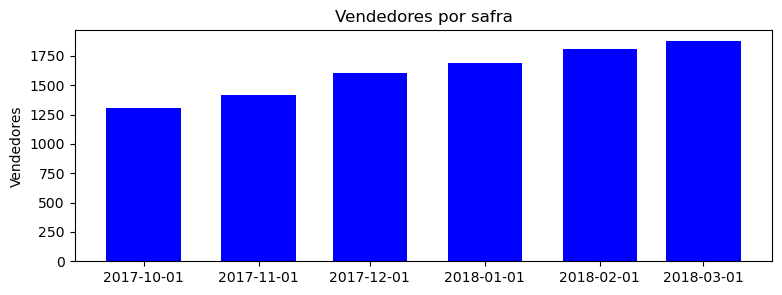

In [15]:
plt.figure(figsize=(9,3))
plt.bar(resumo_safras['safra'], resumo_safras['vendedores'], color='blue', width=20)
plt.xticks(resumo_safras['safra'])
plt.ylabel('Vendedores')
plt.title('Vendedores por safra')
plt.show()


Depois, vamos checar a distribuição da variável target _churn_ em cada uma das safras de treinamento. Isso é importante para ver o quão balanceado ou desbalanceado é o nosso conjunto de dados de treino:

In [16]:
# Como é uma variável 0 ou 1, a média é o mesmo que a proporção de 1
df_abt_safras.groupby('data_ref').agg(proporcao_churn=('churn', 'mean'))

,proporcao_churn
data_ref,
2017-10-01,0.332822
2017-11-01,0.327915
2017-12-01,0.350187
2018-01-01,0.376331
2018-02-01,0.385596
2018-03-01,0.384739


É possível notar que a proporção de "churn" vem aumentando, o que pode ter motivado a busca para uma solução preditiva.

É importante checar se ainda resta algum dado faltante na base de modelagem:

In [17]:
df_abt_safras.isnull().sum()

data_ref              0
seller_id             0
uf                    0
tot_orders_12m        0
tot_items_12m         0
tot_items_dist_12m    0
receita_12m           0
recencia              0
churn                 0
dtype: int64

Por fim, vamos salvar a ABT, em formato csv, para armazenar o trabalho feito até aqui:

In [18]:
df_abt_safras.to_csv('olist_churn_abt.csv', index=False)

## 6. Modelagem e Seleção de Algoritmos

### 6.1 Separação entre dados de treinamento e dados de teste

É importante notar que esse problema de negócios leva em consideração uma variável muito importante: **o tempo**. 

O objetivo do modelo é identificar quais vendedores não realizarão nenhuma venda nos próximos 6 meses (ou os mais propensos a não realizar). 

Dessa forma, a divisão do conjunto de dados em treino e teste convencional (usando uma proporção, ou o método _train_test_split_ da biblioteca _scikit-learn_) não parece adequado.

O ideal é treinar e validar o modelo da **forma mais parecida possível com a qual ele será usado na vida real**, em produção. 
Pensando nisso, usaremos a técnica Out Of Time (OOT), treinando o modelo em nas safras mais antigas e validando na safra mais nova.

In [19]:
# Separando a abt em treino e teste

df_abt = df_abt_safras 

df_train = df_abt.query('data_ref < "2018-03-01"')

df_oot = df_abt.query('data_ref == "2018-03-01"')

### 6.2 Identificando as variáveis de modelagem

Antes de aplicar um algoritmo de aprendizado de máquina, precisamos identificar e tratar as variáveis que serão utilizadas para modelagem. Começaremos separando variáveis por tipo.

In [20]:
# Variáveis chaves da tabela
key_vars = ['data_ref', 'seller_id']

# Variáveis numéricas
num_vars = ['tot_orders_12m', 'tot_items_12m', 'tot_items_dist_12m', 'receita_12m', 'recencia']

# Variáveis categóricas
cat_vars = ['uf']

# Consolidando as features
features = cat_vars + num_vars

# Variável resposta (target)
target = 'churn'

# Conjunto de dados de treinamento
X_train = df_train[features]
y_train = df_train[target]

# Conjunto de dados de teste (Out Of Time)
X_oot = df_oot[features]
y_oot = df_oot[target]


In [21]:
print(X_train.shape, y_train.shape)
print(X_oot.shape, y_oot.shape)

(7816, 6) (7816,)
(1874, 6) (1874,)


### 6.3 Feature Engineering

Após identificar e separar os tipos de variáveis e criar os conjuntos de treino e teste, vamos aplicar transformações que tornem esses conjuntos de dados adequados para modelagem. 

Vamos criar e automatizar um **pipeline de dados**, onde faremos o tratamento de dados faltantes, ajustaremos a escala das variáveis numéricas e faremos o encoding das variáveis categóricas.

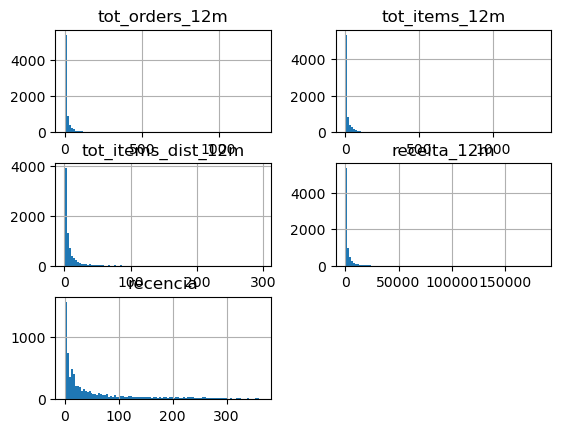

In [24]:
# Checando a distribuição das variáveis numéricas, para decidir o melhor método de imputação de valores faltantes:
X_train.hist(bins=100);


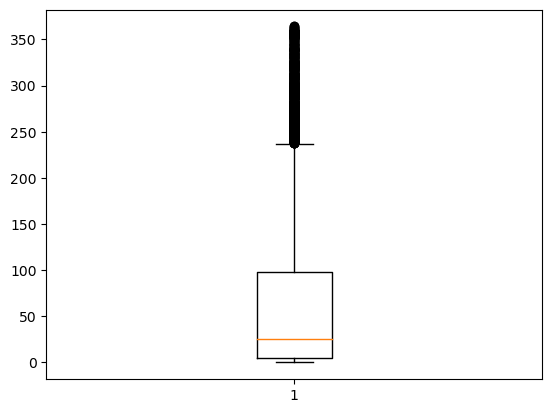

In [25]:
plt.boxplot(X_train['recencia']);

Observando as distribuições, vemos que quase todas as variáveis possuem uma concentração muito grande em valores "baixos", próximos de zero. 

Mas a variável **recencia** é mais dispersa e parece possuir outliers, o que nos leva a crer que a mediana é mais adequada.

Logo, as transformações que faremos consistem em:
- Tratar valores faltantes nas variáveis categóricas, substituindo pela palavra "na";
- Tratar valores faltantes nas variáveis numéricas, substituindo pela mediana;
- Ajustar a escala das variáveis numéricas, usando o método de padronização;
- Transformar as variáveis categóricas em variáveis dummy (binárias);

Outros métodos de transformação podem ser aplicados, de acordo com o algoritmo de aprendizado de máquina escolhido.

### 6.4 Selecionando um algoritmo baseline

Um passo interessante é criar um modelo inicial, com a **solução mais simples possível.** Esse modelo servirá como parâmetro para avaliarmos os ganhos na seleção dos algoritmos.

Em problemas de regressão, uma alternativa seria usar uma regressão linear, ou mesmo a média da variável target.

No nosso caso, como se trata de um problema de classificação binário, vamos usar uma **regressão logística.**

In [26]:
# Criando o pipeline de dados adequado para a Regressão Logística (e para demais modelos lineares)

from sklearn.linear_model import LogisticRegression

lr_model_pipe = Pipeline(steps = [
    ("numeric_imputer", MeanMedianImputer(variables=num_vars, imputation_method = 'median')),           # Usando a mediana para dados numéricos faltantes 
    ("categoric_imputer", CategoricalImputer(variables=cat_vars, fill_value = "na")),                   # Atribuindo o valor "na" para as variáveis categóricas faltantes
    ("numeric_scaler", SklearnTransformerWrapper(variables=num_vars, transformer = StandardScaler())),  # Padronizando as variáveis numéricas para terem média 0 e variância 1
    ("one_hot_encoder", OneHotEncoder(variables=cat_vars)),                                             # Utilizando o OneHotEncoder para transformar as variáveis categóricas em variáveis binárias
    ("algoritmo", LogisticRegression(random_state=42))                                                  # Definindo o algoritmo a ser aplicado
])


# Para o treinamento (ajuste) do algoritmo, vamos usar a técnica de validação cruzada estratificada em 3 folds

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate

skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

results = cross_validate(estimator = lr_model_pipe, X=X_train[features], y=y_train, scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'], cv=skf , n_jobs=-1)

# Abaixo os resultados em cada um dos folds
df_results = pd.DataFrame(results)
df_results

,fit_time,score_time,test_accuracy,test_precision,test_recall,test_f1,test_roc_auc
0,0.475574,0.047445,0.830391,0.834473,0.655209,0.734055,0.900724
1,0.475574,0.047445,0.825720,0.835211,0.637634,0.723171,0.889974
2,0.475574,0.047445,0.826104,0.840228,0.633333,0.722256,0.893528


Treinando o modelo final:

In [27]:
lr_model_pipe.fit(X_train, y_train);

**Observando as métricas de classificação:**

Matriz de Confusão nos dados de treino:

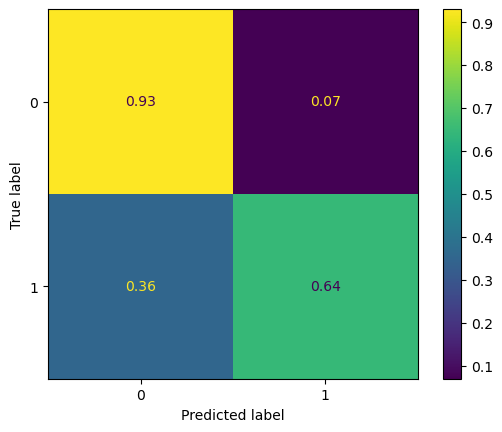

In [28]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(estimator= lr_model_pipe, X=X_train, y=y_train, normalize='true');

Matriz de Confusão nos dados Out Of Time:

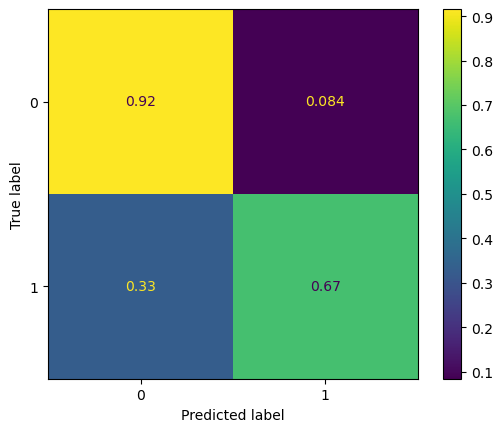

In [29]:
ConfusionMatrixDisplay.from_estimator(estimator= lr_model_pipe, X=X_oot, y=y_oot, normalize='true');

É importante notar que o _recall_ está baixo tanto nos dados de treinamento quanto nos dados de teste. Isso significa que o modelo de regressão logística está tendo dificuldade de detectar o fenômeno que está sendo modelado. Mais de 30% dos casos de "churn" _(True label = 1)_ está sendo erroneamente classificado como "não churn" _(Predicted label = 0)_. 

Pensando na aplicação do modelo, seria interessante ter um modelo que informasse a probabilidade do vendedor não realizar uma venda. Isso daria à Olist a vantagem de decidir como atuar (selecionar os 10% mais propensos, ou os 500 vendedores mais propensos, ou todos que tiverem probabilidade maior que 70%...), podendo calibrar os gastos com cupons.

Além disso, no nosso problema, tanto a precisão nas predições quanto a capacidade de detecção do modelo são importantes. Logo, parece apropriado avaliar os modelos pela área sob a curva ROC, conhecida como **ROC AUC**, que é uma métrica que combina precision e recall.

Além disso,  a ROC AUC é uma métrica calculada sobre a probabilidade (probabilidade do vendedor não realizar uma venda), que independe do ponto de corte (threshold) adotado.


ROC AUC

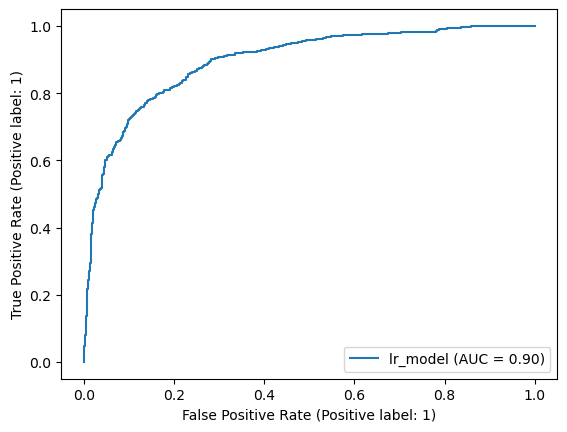

In [30]:
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_estimator(lr_model_pipe, X_oot, y_oot, name= 'lr_model');

Abaixo, vamos automatizar um resumo das principais métricas de classificação, que facilitará a avaliação e seleção de algoritmos:

In [31]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

metricas = {
    'modelo': ['Logistic Regression', 'Logistic Regression'],
    'dados': ['treino', 'oot'],
    'accuracy': [accuracy_score(y_train, lr_model_pipe.predict(X_train)), accuracy_score(y_oot, lr_model_pipe.predict(X_oot))],
    'precision': [precision_score(y_train, lr_model_pipe.predict(X_train)), precision_score(y_oot, lr_model_pipe.predict(X_oot))],
    'recall': [recall_score(y_train, lr_model_pipe.predict(X_train)), recall_score(y_oot, lr_model_pipe.predict(X_oot))],
    'f1_score': [f1_score(y_train, lr_model_pipe.predict(X_train)), f1_score(y_oot, lr_model_pipe.predict(X_oot))],
    'roc_auc': [roc_auc_score(y_train, lr_model_pipe.predict_proba(X_train)[:,1]), roc_auc_score(y_oot, lr_model_pipe.predict_proba(X_oot)[:,1])]

}

pd.DataFrame(metricas)

,modelo,dados,accuracy,precision,recall,f1_score,roc_auc
0,Logistic Regression,treino,0.828301,0.837134,0.644572,0.728340,0.89645
1,Logistic Regression,oot,0.821238,0.832759,0.669903,0.742506,0.89603


### 6.5 Treinando e comparando vários algoritmos para selecionar o melhor modelo

Assim como fizemos para o modelo de regressão logística, vamos criar e automatizar pipelines de dados para os demais algoritmos que serão treinados:

In [32]:
# Garantindo que o as partes aleatórias sejam passíveis de reprodução
random_state = 42

# Modelos lineares

lin_models = [
    ('Logistic_Regression', LogisticRegression(random_state=random_state)),
    ('SVM', SVC (random_state=random_state))
]

steps_lin_models = [
    ('numeric_imputer', MeanMedianImputer(variables=num_vars, imputation_method='median')),
    ('numeric_scaler', SklearnTransformerWrapper(variables=num_vars, transformer=StandardScaler())),
    ('categoric_imputer', CategoricalImputer(variables=cat_vars, fill_value='na')),
    ('one_hot_encoder', OneHotEncoder(variables=cat_vars))
]

# Modelos de árvores

tree_models =[
    ('decision_tree', DecisionTreeClassifier(random_state=random_state)),
    ('random_forest', RandomForestClassifier(random_state=random_state)),
    ('gradient_boost', GradientBoostingClassifier(random_state=random_state)),
    ('xgb', XGBClassifier(random_state=random_state)),
    ('lgbm', LGBMClassifier(random_state=random_state)),
    ('catboost', CatBoostClassifier(random_state=random_state, allow_writing_files=False))
]

steps_tree_models = [
    ('numeric_imputer', MeanMedianImputer(variables=num_vars, imputation_method='median')),
    ('categoric_imputer', CategoricalImputer(variables=cat_vars, fill_value='na')), 
    ('one_hot_encoder', OneHotEncoder(variables=cat_vars))
]

df_results = pd.DataFrame(columns=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'])


Para realizar o treinamento de todos os modelos de forma mais automática, criaremos uma função que prepara os dados utilizando os pipelines criados anteriormente e retorna as métricas de cada algoritmo.

In [33]:
def model_training (model, steps, X_train, y_train, cv, random_state, n_jobs=-1):
    pipeline = Pipeline(steps=steps + [model])
    result_cv = cross_validate(estimator=pipeline, X=X_train, y=y_train, 
                               scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'], cv=cv, n_jobs=n_jobs)
    df_temp = pd.DataFrame(result_cv)
    df_cv = df_temp.mean()
    
    return [
        df_cv.loc['test_accuracy'],
        df_cv.loc['test_precision'],
        df_cv.loc['test_recall'],
        df_cv.loc['test_f1'],
        df_cv.loc['test_roc_auc']
    ]

In [34]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)

for model in lin_models:       # model é uma tupla, onde o primeiro elemento é o nome do modelo e o segundo elemento é o algoritmo
    model_name = model[0]
    print(f'Treinando {model_name} ...', end=' ')
    aux = model_training(model, steps_lin_models, X_train, y_train, skf, random_state)  #aplica a funçao model_training
    df_results.loc[model_name] = aux
    print('OK')

for model in tree_models:
    model_name = model[0]
    print(f'Treinando {model_name} ...', end=' ')
    aux = model_training(model, steps_tree_models, X_train, y_train, skf, random_state) # a única diferença é o step do pipeline
    df_results.loc[model_name] = aux
    print('OK')

Treinando Logistic_Regression ... OK
Treinando SVM ... OK
Treinando decision_tree ... OK
Treinando random_forest ... OK
Treinando gradient_boost ... OK
Treinando xgb ... OK
Treinando lgbm ... OK
Treinando catboost ... OK


In [35]:
df_results.sort_values(by='roc_auc', ascending=False)

,accuracy,precision,recall,f1,roc_auc
xgb,0.870906,0.839967,0.788966,0.813601,0.933215
catboost,0.852993,0.822275,0.750986,0.784914,0.921290
random_forest,0.854784,0.829855,0.746681,0.785949,0.920666
lgbm,0.850307,0.819271,0.745611,0.780590,0.918320
gradient_boost,0.838536,0.802422,0.726980,0.762753,0.908054
Logistic_Regression,0.827149,0.835396,0.642774,0.726422,0.894439
SVM,0.831627,0.829665,0.664992,0.738194,0.889676
decision_tree,0.769700,0.676701,0.680751,0.678641,0.749865


Vemos que o algoritmo com melhor performance em validação cruzada foi o **XGBoost**. 

Agora, treinaremos esse modelo no conjunto de dados de treinamento e realizaremos as previsões na base de validação (OOT).

In [36]:
best_model = Pipeline(steps=steps_tree_models + [tree_models[3]])   # Selecionando o xgboost
best_model.fit(X_train, y_train);

Para realizar as predições, vamos usar o método **predict_proba**. 

No nosso caso, o output do predict_proba é um ARRAY com 2 colunas: 

- 1ª coluna: probabilidade do vendedor pertencer à classe 0 ("não churn")
- 2ª coluna: probabilidade do vendedor pertencer à classe 1 ("churn").

Logo, o y predito corresponde à segunda coluna do array. Por isso o slice [:,1]

In [37]:
y_proba_oot = best_model.predict_proba(X_oot)[:,1]

Calculando a ROC AUC nos dados Out of Time:

In [85]:
roc_auc_oot = roc_auc_score(y_oot, y_proba_oot)
print(f'RoC-AUC: {roc_auc_oot:.4f}')

RoC-AUC: 0.9228


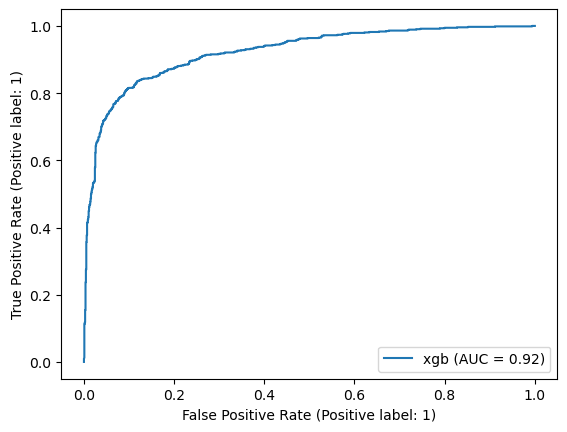

In [39]:
RocCurveDisplay.from_predictions(y_true=y_oot, y_pred= y_proba_oot, name= 'xgb');

**O modelo apresenta uma ROC AUC de 92% nos dados de validação Out of Time.**

Isso significa que o modelo possui uma boa capacidade de ordenação. 
Ou seja, a capacidade do modelo de atribuir _scores_ de churn está adequada.

Em outras palavras: Um vendedor que não realizará uma venda (pertence a classe positiva) tem 92% de chance de receber uma probabilidade de churn maior do que um vendedor que realizará uma venda (pertence à classe negativa).


## 7. Aperfeiçoamento do Modelo

Uma vez encontrado um algoritmo que se parece se adequar de forma satisfatória ao nosso conjunto de dados, vamos buscar melhorar a performance do algoritmo, através de hiperparâmetros.

No caso do Xgboost, podemos trabalhar com alguns hiperparâmetros principais:

* **learning_rate:** Taxa de aprendizagem _(eta)_. Esse fator determina o avanço a cada etapa de aprendizado do modelo. Quanto menor a learning rate, maior o tempo de processamento e mais árvores serão necessárias para convergir. Varia entre 0 e 1.
* **n_estimators:** Quantidade de árvores na Random Forest.
* **max_depth:** Profundidade da árvore. Vai aumentando até que cada folha atinja o valor mínimo de amostras estabelecido no parâmetro min_samples_split.
* **colsample_bytree:** Indica a fração de atributos usados por rodada.
* **subsample:** Indica a fração das amostras usadas a cada rodada.

In [91]:
pipeline = Pipeline(steps=steps_tree_models + [tree_models[3]])   # Composto pelo steps_tree_models + XGBoost

params = {
    'xgb__learning_rate': [0.05, 0.1],
    'xgb__n_estimators': [400, 500],
    'xgb__max_depth': [15, 20],
    'xgb__colsample_bytree': [0.5, 0.6],
    'xgb__subsample': [0.7, 0.9],
}


grid_search = GridSearchCV(pipeline, params, scoring='roc_auc', cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

print()
print('='*100)
print(grid_search.best_params_)
print('='*100)
print()

Fitting 5 folds for each of 32 candidates, totalling 160 fits

{'xgb__colsample_bytree': 0.5, 'xgb__learning_rate': 0.1, 'xgb__max_depth': 20, 'xgb__n_estimators': 400, 'xgb__subsample': 0.7}



In [92]:
# Cria o modelo final, após encontrar os melhores hiperparâmetros

modelo_grid = [('xgb_final', XGBClassifier(random_state = random_state,  
                                           colsample_bytree = 0.5, 
                                           learning_rate = 0.1, 
                                           max_depth = 20, 
                                           n_estimators = 400, 
                                           subsample= 0.7 ))]

In [93]:
modelo_final = Pipeline(steps=steps_tree_models + modelo_grid) 

In [94]:
# Treina o modelo final nos dados de treinamento

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)

for model in modelo_grid:       # model é uma tupla, onde o primeiro elemento é o nome do modelo e o segundo elemento é o algoritmo
    model_name = model[0]
    print(f'Treinando {model_name} ...', end=' ')
    aux = model_training(model, steps_tree_models, X_train, y_train, skf, random_state) # a única diferença é o step do pipeline
    df_results.loc[model_name] = aux
    print('OK')

df_results.sort_values(by='roc_auc', ascending=False)

Treinando xgb_final ... OK


,accuracy,precision,recall,f1,roc_auc
xgb_final,0.892401,0.867616,0.824442,0.845439,0.949430
xgb,0.870906,0.839967,0.788966,0.813601,0.933215
catboost,0.852993,0.822275,0.750986,0.784914,0.921290
random_forest,0.854784,0.829855,0.746681,0.785949,0.920666
lgbm,0.850307,0.819271,0.745611,0.780590,0.918320
gradient_boost,0.838536,0.802422,0.726980,0.762753,0.908054
Logistic_Regression,0.827149,0.835396,0.642774,0.726422,0.894439
SVM,0.831627,0.829665,0.664992,0.738194,0.889676
decision_tree,0.769700,0.676701,0.680751,0.678641,0.749865


Podemos ver que os ajustes de hiperparâmetros melhoraram consideravelmente a performance do modelo. Tanto a ROC AUC, que adotamos como métrica do nosso problema, quanto todas as métricas comumente usadas para problemas de classificação ficaram acima dos algoritmos treinados anteriormente.

Agora vamos treinar o modelo final no conjunto de dados de treinamento:

In [95]:
modelo_final.fit(X_train, y_train);

Realizar as predições com o novo modelo:

In [96]:
# Realiza as predições com o modelo final

y_proba_oot_fim = modelo_final.predict_proba(X_oot)[:,1]

E extrair as métricas do modelo final:

In [104]:
metricas_final = {
    'modelo': ['xgb_final'],
    'dados': ['oot'],
    'accuracy': [accuracy_score(y_oot, modelo_final.predict(X_oot))],
    'precision': [precision_score(y_oot, modelo_final.predict(X_oot))],
    'recall': [recall_score(y_oot, modelo_final.predict(X_oot))],
    'f1_score': [f1_score(y_oot, modelo_final.predict(X_oot))],
    'roc_auc': [roc_auc_score(y_oot, modelo_final.predict_proba(X_oot)[:,1])]

}

pd.DataFrame(metricas_final)

,modelo,dados,accuracy,precision,recall,f1_score,roc_auc
0,xgb_final,oot,0.870331,0.848397,0.807212,0.827292,0.925425


In [98]:
# Calcula a ROC AUC do modelo final nos dados Out Of Time
roc_auc_oot_fim = roc_auc_score(y_oot, y_proba_oot_fim)
print(f'ROC-AUC: {roc_auc_oot_fim:.4f}')

ROC-AUC: 0.9254


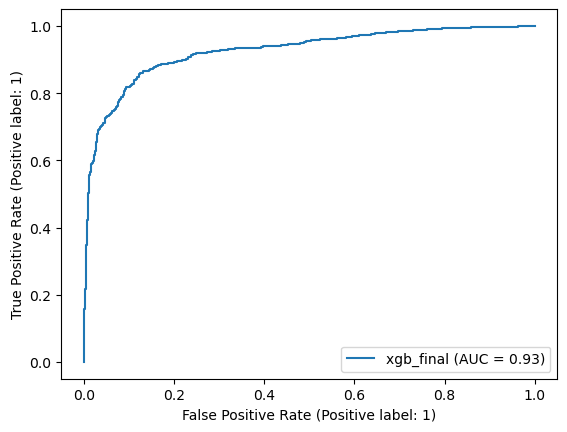

In [99]:
# Plota a ROC AUC do modelo final nos dados Out Of Time
RocCurveDisplay.from_predictions(y_true=y_oot, y_pred= y_proba_oot_fim, name= 'xgb_final');

Agora temos um modelo ainda melhor, com uma ROC AUC de 0.93 nos dados de teste (out of time).

## 8. Apresentação da Solução

**Para ouvintes técnicos, como CRM e times de Dados:**

Temos aqui um modelo de classificação de churn (o vendedor irá ou não realizar uma venda nos próximos 6 meses).
O algoritmo de machine learning que melhor se ajusta ao problema é o XGBoost, um algoritmo ensemble baseado em árvores que, como o nome sugere, é otimizado através de gradient boosting.

Os modelos foram avaliados nas principais métricas para problemas de classificação, e foi escolhido o modelo que possuía maior área sob a curva ROC, dado que a aplicação do modelo pelo time de Negócio requer um bom nível de ordenação.

O modelo foi construído na visão de safras. Para treinamento, foi utilizada validação cruzada em dados de 5 safras, e os dados de teste eram compostos por uma safra "nova" (out of time), que o modelo não conhecia.

Abaixo um resumo da performance do modelo, em dados de teste (oot):
- ROC AUC: 0,93;
- Precision: 0,85
- Recall: 0,81
- F1 Score: 0,83    

**Para ouvintes não técnicos, como áreas de Negócios:**

Temos aqui um modelo capaz de prever se o **vendedor irá ou não realizar uma venda nos próximos 6 meses** _(churn)_.  

O modelo apresentado possui uma precisão de mais de 86%.  
Isso significa que, para cada 100 vendedores que o modelo aponta que não vão vender, pelo menos 86 realmente não vão.

O modelo também detecta mais de 82% dos casos de churn.  
Em outras palavras: de 100 vendedores que não vão realizar uma venda, o modelo é capaz de detectar pelo menos 82.
    
Além disso, esse modelo consegue ordenar os vendedores mais propensos a não realizarem uma venda, com uma assertividade de 93%.  
Isso implica que, caso seja viável para o Negócio, **é possível extrair uma lista com os "top vendedores mais propensos a não realizarem uma venda"**, para direcionar os gastos com cupons apenas no público-alvo mais crítico.  
_Ex: Atuar nos 100 vendedores mais propensos a não realizar nenhuma venda._

Outro ponto de versatilidade desse modelo, é que ele retorna a probabilidade do vendedor não realizar uma venda. 
Isso empodera a área de Negócio, que pode definir o **ponto de corte para realizar alguma ação**, calibrando os gastos com cupom.  
_Ex: Atuar apenas nos vendedores com mais de 70% de chance de não realizar uma venda._
    

## 9. Implementação e Monitoramento

### 9.1 Implementação

Depois de todo o desenvolvimento, o modelo será salvo e posteriormente, disponibilizado em um arquivo único, para que seja colocado em produção.

Primeiro, salvaremos o modelo final em um arquivo .pkl:

In [107]:
with open('olist_churn_xgb.pkl', 'wb') as file_w:
    pickle.dump(modelo_final, file_w)

Agora, o modelo pode ser carregado facilmente, para que seja feito o _deploy_:

In [108]:
with open('olist_churn_xgb.pkl', 'rb') as file_r:
    modelo_xgb = pickle.load(file_r)

modelo_xgb

Pipeline(steps=[('numeric_imputer',
                 MeanMedianImputer(variables=['tot_orders_12m', 'tot_items_12m',
                                              'tot_items_dist_12m',
                                              'receita_12m', 'recencia'])),
                ('categoric_imputer',
                 CategoricalImputer(fill_value='na', variables=['uf'])),
                ('one_hot_encoder', OneHotEncoder(variables=['uf'])),
                ('xgb_final',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsam...
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_de

### 9.2 Monitoramento

Aqui não cabe simular o monitoramento do modelo. 

Mas, como é um modelo para prever um **comportamento**, baseado em safras, é importante **monitorar se o perfil dos vendedores muda ao longo do tempo.**  

Uma forma simples de detectar essa mudança é avaliar se as **distribuições(ou as medidas de dispersão)** das variáveis usadas no modelo estão se alterando com o passar do tempo (safras).  

Se isso for verificado, pode ser necessário **retreinar o modelo com novas safras e avaliar o resultado.** Dessa forma, o modelo se mantém atualizado.  

No caso de mudanças mais extremas, pode ser necessário construir um novo modelo, que se adeque melhor aos novos dados.

# <center> Fim </center>